# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import time
import os

# Load datasets from storage
training_file = "train.p"
testing_file = "test.p"
logs_path = os.getcwd()+'/tmp/tensorflow_logs/example'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print("Shape of original training data ",X_train.shape, y_train.shape)
print("Shape of original testing data ",X_test.shape, y_test.shape)

Shape of original training data  (39209, 32, 32, 3) (39209,)
Shape of original testing data  (12630, 32, 32, 3) (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Preprocess the data here.
def normalize(data):
    a=0.1
    b=0.9
    greyscale_min=0
    greyscale_max=255
    return a + ( ( (data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

In [3]:
from skimage import transform as tr
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

# Perform augmentation on a dataset and return a dataset with all labels having the same number of samples "class_freq"
def augment(xdata,ydata,class_freq=2500):
    classes,counts=np.unique(ydata,return_counts=True)
    required_xdata = np.subtract(class_freq,counts)
    tempx = np.zeros(((np.sum(np.subtract(class_freq,counts))),32,32,1))
    tempy = np.zeros(((np.sum(np.subtract(class_freq,counts))),))
    for x in range(43):
        ims_need = required_xdata[x]
        for y in range(ims_need):
            r = random.randint(0,counts[x]-1)
            rand = random.randint(1,4) # Perform any of the four given augmentation
            im = xdata[np.sum(counts[0:x])+r]
            if(rand == 1): # Translation
                shiftx = random.randint(-2,2)
                shifty = random.randint(-2,2)
                t_translate = tr.SimilarityTransform(translation=[shiftx,shifty])
                im = tr.warp(im,t_translate)
            elif(rand == 2): # Rotation
                ang = random.randint(-15,15)
                im = tr.rotate(im,ang)
            elif(rand == 3): # Scaling
                scale = random.uniform(0.90,1.10)
                t_scale = tr.SimilarityTransform(scale=scale)
                im = tr.warp(im,t_scale)
#             elif(rand == 4):   
#                 im = tr.pyramid_expand(xdata[i])
#                 im = tr.rescale(im,0.5)
            elif(rand == 4): # Affine Transformation
                shiftx = random.randint(-2,2)
                shifty = random.randint(-2,2)
                ng = random.uniform(-np.deg2rad(15),np.deg2rad(15))
                sc = random.uniform(0.90,1.10)
                taffine = tr.AffineTransform(scale = (sc,sc),rotation = ng ,translation = (shiftx,shifty))
                im = tr.warp(im,taffine)
#             else:
#                 continue
            tempx[np.sum(required_xdata[0:x])+y] = im
            tempy[np.sum(required_xdata[0:x])+y] = ydata[np.sum(counts[0:x])+r]
        
    return tempx,tempy


In [4]:
# Change color mode of orginal training dataset
for i in range(X_train.shape[0]):
    X_train[i] = cv2.cvtColor(X_train[i],cv2.COLOR_BGR2YUV)

# Use only grayscale data of the resultant YUV color mode (i.e the Y-channel)
X_train = X_train[:,:,:,0:1]

# Normalize the data into values 
X_train = normalize(X_train)
    
# Produce larger datasets through augmentation
start = time.time()
print("Augmenting.....")
xt,yt=augment(X_train,y_train,class_freq=5000)
X_train = np.append(X_train,xt,axis=0)
y_train = np.append(y_train,yt,axis=0)
print("Time it took to augment ",time.time()-start)

print("Shape of balanced training dataset ",X_train.shape)
print("Size of labels ",y_train.shape)

Augmenting.....
Time it took to augment  31.36697006225586
Shape of balanced training dataset  (215000, 32, 32, 1)
Size of labels  (215000,)


In [5]:
### Replace each question mark with the appropriate value.
import numpy as np
EPOCHS = 2
BATCH_SIZE = 100

# TODO: Number of training examples
n_original_train = X_train.shape[0]

# TODO: Number of examples in actual training set (-validation)
n_train = int(((X_train.shape[0]+1)/30)*0.9)*30

# TODO: Number of training examples
n_validation = X_train.shape[0]-n_train

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
_,n_classes = np.unique(y_train,return_counts=True)

print("Number of original training examples =", n_original_train)
print("Number of testing examples =", n_test)
print("Number of classes =", len(n_classes))
print(n_classes)
print("Length of training set =", n_train)
print("Length of validation set =", n_validation)
print("Image data shape =", image_shape)
# print(X_train.num_examples)

Number of original training examples = 215000
Number of testing examples = 12630
Number of classes = 43
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Length of training set = 193500
Length of validation set = 21500
Image data shape = (32, 32, 1)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** The images are first converted to the YUV color mode. The U and V (color information) is removed to finally give a grayscale image. Next, the grayscale images are normalized such that each pixel has a value between 0.1 and 0.9.

- Reasons for converting images to grayscale are multifold:
    * Grayscale images are immune to variations in lighting, such as extreme shadows or bright sunshine. 
    * Grayscale images are much lesser in size as they are only one layer deep (without the color information) making processing much faster
    * The U and V information in traffic signs did not yield any better results during testing. My thinking is that they let some brightness noise to creep in and spoil the data. Although, it must be noted that color information should theoretically help better distinguish between different signs (e.g a *parking sign* which is red and a *left turn ahead* sign which is predominantly blue)


- The main reason for normalizing images is to reduce the intensity variations caused in grayscale images due to the variable lighting effects in the original colored data. This helps two same signs with different lighting conditions to be seen as the same by the model, instead of two different images, thus helping in better generalizatioin of the model.

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.


# Total tracks = Total images/30 where 30 is the number of frames per second
tot_tracks = int(X_train.shape[0]/30)

# rand_train stores random values that will later be used to select random tracks from the training set
rand_train = np.random.choice(np.arange(0,tot_tracks),replace=False,size=int((n_train+n_validation)/30))

# Initialize simple arrays for datasets
X_training = []
y_training = []
X_validation = []
y_validation = []

# Split training dataset by randomly distributing its "tracks" into training and validation  
for x in range(len(rand_train)):
    for y in range(30):
        if(x>=n_validation/30):
            X_training.append(X_train[(rand_train[x]*30)+y])
            y_training.append(y_train[(rand_train[x]*30)+y])
        else:
            X_validation.append(X_train[(rand_train[x]*30)+y])
            y_validation.append(y_train[(rand_train[x]*30)+y])

# Final packing of the training and validation datasets
X_training = np.array(X_training)
y_training = np.array(y_training,dtype=np.int32)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation,dtype=np.int32)

# Perform color modifications and normalization on the testing data, same as above
X_testing = X_test[0:n_test]
y_testing = y_test[0:n_test]

for i in range(n_test-1):
    X_testing[i] = cv2.cvtColor(X_testing[i],cv2.COLOR_BGR2YUV)
X_testing = X_testing[:,:,:,0:1]

# Perform normalization
X_testing = normalize(X_testing)

print("Shape of the final training dataset",X_training.shape)
print("Shape of the final validation dataset",X_validation.shape)
print("Shape of the final testing dataset",X_testing.shape)

Shape of the final training dataset (193470, 32, 32, 1)
Shape of the final validation dataset (21510, 32, 32, 1)
Shape of the final testing dataset (12630, 32, 32, 1)


Index of image  187720
Label for the below image:  13


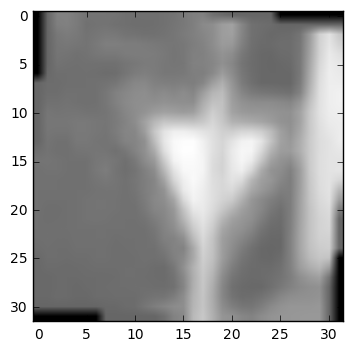

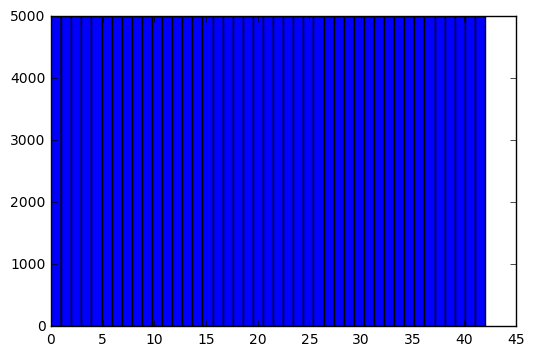

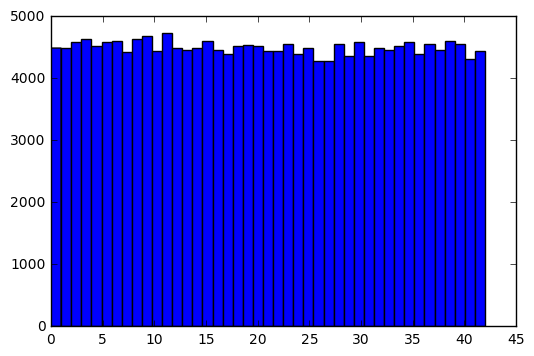

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage import transform as tr
%matplotlib inline

# Check if the images and their corresponding labels match after pre-processing stage is over
index = random.randint(0, len(X_training))
print("Index of image ",index)
print("Label for the below image: ",y_training[index])
plt.imshow(X_training[index,:,:,0],cmap="gray")
plt.show()
plt.hist(y_train,bins=len(n_classes))
plt.show()
plt.hist(y_training,bins=len(n_classes))
plt.show()

### Data balancing

As can be seen in the first histogram above, all labels have been given an equal number of images (5000 in this case) so that the unbalanced original data does not cause any learning biases in the trained model. This technique has helped propel the model above 97% testing accuracy. 

The second histogram shows the balancing in the training set after a random split was done to generate the validation and training sets. Due to non-perfect randomness, the training set has a slight uneveness to it. However, this change can be considered negligible in the grand scheme of things as the standard deviation is less than 5% for all labels. So, we move on. 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** This part was a little tricky.

Most answers given on the forums suggest creating a validation data set from the training data using a randomized function in a 80-20% fashion where the validation set gets 20% of the training set images randomly. 
However, this [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) and the original [website for the GTSRB data](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) point out an important structural characterstic of the data. The original training data is divided into tracks where each track represents 30 frames of a video shooting a traffic sign. Consequentially, each track consists of 30 images of the same traffic sign as the camera approaches and then passes the sign in the original video. This is important because during preparation of the validation dataset, if we do selections totally randomly, then we end up creating a validation set that has literally the same signs as the training dataset, thus creating a massive bias while training the model on the training dataset. 

As pointed out by various questions on the forums, most cohorts are having a problem with overfitting and assume that there is a problem in the data. I think the problem here is caused by the above mentioned error in dataset creation, as the validation and training dataset are essentially the same, thus creating an overly good validation test accuracy (the lesson where the LeNet architecture is tested, validation accuracy is an abnormal 95%). 

Here, I created a custom randomization where "tracks" are randomly distributed into validation and training datasets instead of images, which should rectify the above mentioned problem.

Once a reviewer validates this viewpoint, I'll share this on the forums for the future cohorts.

Next, the training data has been augmented by creating several variations of the original data and then adding them to the finalized training dataset. The augmentation involves random scaling, translation, rotation and affine transformations of the original images. The affine Transformation is done as it maintains parallelism of lines, but can change the perspective through which to look at the object (traffic sign in this case). The other transformations are simple ways of adding some robustness to the model. In total, a training set containing 108,000 images is used for training. 

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten
# Hyperparameters
mu = 0
sigma = 0.1
c1 = 32
c2 = 64
f1 = 100

# Variables defined above so that they can be accessed by saver module later
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, c1), mean = mu, stddev = sigma),name="w1")
conv1_b = tf.Variable(tf.zeros(c1),name='b1')
    
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, c1, c2), mean = mu, stddev = sigma),name='w2')
conv2_b = tf.Variable(tf.zeros(c2),name='b2')

fc1_W = tf.Variable(tf.truncated_normal(shape=(7872, f1), mean = mu, stddev = sigma),name='w3')
fc1_b = tf.Variable(tf.zeros(f1),name='b3')

fc3_W  = tf.Variable(tf.truncated_normal(shape=(f1, 43), mean = mu, stddev = sigma),name='w4')
fc3_b  = tf.Variable(tf.zeros(43),name='b4')

def LeNet(x):    
    
    
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = tf.nn.dropout(conv1,keep_prob)

    # Create a summary to visualize the first layer Dropout activation
    tf.summary.histogram("First_layer_Dropout", conv1)
    
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    conv2 = tf.nn.relu(conv2)

    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Create a summary to visualize the second layer Max Pool activation
    tf.summary.histogram("Second_layer_MaxPool", conv2)
    
    fcx = flatten(conv2)
    fcy = flatten(conv1)
    fc0 = tf.concat(1,[fcy,fcx])
#     print(int(fc0.get_shape()[1]))
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1,keep_prob)

    # Create a summary to visualize the first layer ReLU activation
    tf.summary.histogram("First_Classifier_Dropout", fc1)
    
    logits = tf.matmul(fc1, fc3_W) + fc3_b
    
    # Create a summary to visualize the first layer ReLU activation
    tf.summary.histogram("Final_Classifier", logits)

    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 

The architecture uses 4 layers.

Layer 1: A convolutional layer with 32 5*5 filters performing a convolution on 32 by 32 grayscale normalized images. Activation used is Rectified Linear followed by Max Pooling to reduce the size by half. Finally a dropout is used so as to contain excessive noise generating from lower stage layers that may cause overfitting in the end. 

Layer 2: A convolutional layer with 64 5*5 filters performing a convolution on the 32 layer deep output from layer 1. A Rectified Linear activation and Max Pooling are performed next. However, no dropouts are used in-order to preserve more information at this stage.

Layer 3: A classifier layer with a width of 100 hidden units. It takes as input the flattened output of Layer 2 and performs matrix multiplication and addition in the form "Wx + b" to gain classifier level information. The output is 100 units wide. Additionally, a dropout at this stage proved to help with overfitting.

Layer 4: The final classifier with a width of 43 hidden units. Performs the same operation as Layer 3 and outputs a 43 unit wide array that matches the one_hot_y label array in shape. This is also the final output of the model and is used to process accuracy and loss. 

In summary, the architecture is a variation of the LeNet architecture with the only difference of multi-scaling. Here, the output from the lowest layer is also used in the final classifier layers, so as to give the model a "feel" for low lever details (like short lines and arcs) along with high level details (complex shapes like a right turn, parking sign, etc) of an image. Also the classifier is a 2-stage classifier, wherein the additional depth in the classifier helps with better generalizations and accuracy. 

![Model](model.png)


In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, len(n_classes))

In [10]:
# learning rate
rate = 0.001

keep_prob = tf.placeholder(tf.float32) # probability to keep units
with tf.name_scope('Model'):
    logits = LeNet(x)
with tf.name_scope('Loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)
with tf.name_scope('AdamOptimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)
with tf.name_scope('Accuracy'):
    # Accuracy
    acc = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_opera = tf.reduce_mean(cross_ent)
# print(conv1_W)
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy,loss = sess.run([accuracy_operation,loss_opera], feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_loss += (loss * len(batch_x))
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples , total_loss/num_examples

# Initializing the variables
init = tf.global_variables_initializer()

# Create a summary to monitor cost tensor
tf.summary.scalar("Loss", loss_operation)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("Accuracy", acc)
# Create summaries to visualize weights
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)
# Summarize all gradients
# for grad, var in grads:
#     tf.histogram_summary(var.name + '/gradient', grad)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()



INFO:tensorflow:Summary name w1:0 is illegal; using w1_0 instead.
INFO:tensorflow:Summary name b1:0 is illegal; using b1_0 instead.
INFO:tensorflow:Summary name w2:0 is illegal; using w2_0 instead.
INFO:tensorflow:Summary name b2:0 is illegal; using b2_0 instead.
INFO:tensorflow:Summary name w3:0 is illegal; using w3_0 instead.
INFO:tensorflow:Summary name b3:0 is illegal; using b3_0 instead.
INFO:tensorflow:Summary name w4:0 is illegal; using w4_0 instead.
INFO:tensorflow:Summary name b4:0 is illegal; using b4_0 instead.


In [12]:
saver = tf.train.Saver({"w1": conv1_W,"b1": conv1_b,"w2": conv2_W,"b2": conv2_b,"w3": fc1_W,"b3": fc1_b,"w4": fc3_W,"b4": fc3_b})
with tf.Session() as sess:
    sess.run(init)
    num_examples = len(X_training)
    val_arr = np.zeros((EPOCHS+1))
     # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path,graph=tf.get_default_graph())

    # Restore model that was pre-trained and check validation accuracy 
    saver.restore(sess,os.getcwd()+'/tmp/model.ckpt')
    X_validation, y_validation = shuffle(X_validation, y_validation)
    validation_accuracy, loss_val = evaluate(X_validation, y_validation)
    print("Last best validation accuracy = {:.3f} and {}".format(validation_accuracy,loss_val))
#     val_arr[EPOCHS] = validation_accuracy
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        start = time.time()
        X_training, y_training = shuffle(X_training, y_training)
        X_validation, y_validation = shuffle(X_validation, y_validation)

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_training[offset:end], y_training[offset:end]
            op,summary = sess.run([training_operation,merged_summary_op], 
                                  feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
             # Write logs at every iteration
            summary_writer.add_summary(summary, i * num_examples/BATCH_SIZE + offset)
            
        training_accuracy, loss_train = evaluate(X_training,y_training)#X_train[:,:,:,0:1],y_train)
        validation_accuracy, loss_val = evaluate(X_validation, y_validation)

        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f} \tTraining Loss = {}".format(training_accuracy,loss_train))
        print("Validation Accuracy = {:.3f} \tValidation Loss = {}".format(validation_accuracy,loss_val))
        print("Time for this EPOCH = ",time.time()-start)

        if(validation_accuracy>=val_arr.max()):
            saver.save(sess, os.getcwd()+'/tmp/model.ckpt')
            print("Model saved")
        val_arr[i] = validation_accuracy
    print("Training completed")

Last best validation accuracy = 0.994 and 0.02392202830946602
Training...

EPOCH 1 ...
Training Accuracy = 0.996 	Training Loss = 0.01721746597800268
Validation Accuracy = 0.995 	Validation Loss = 0.023811848844575375
Time for this EPOCH =  686.4900209903717
Model saved
EPOCH 2 ...
Training Accuracy = 0.995 	Training Loss = 0.01924431956484149
Validation Accuracy = 0.993 	Validation Loss = 0.0279413005180708
Time for this EPOCH =  645.694687128067
Training completed


In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    try:
        saver
    except:
        saver = tf.train.Saver({"w1": conv1_W,"b1": conv1_b,"w2": conv2_W,"b2": conv2_b,"w3": fc1_W,"b3": fc1_b,"w4": fc3_W,"b4": fc3_b})
    saver.restore(sess,os.getcwd()+'/tmp/model.ckpt')
    print(X_testing.shape)
    test_accuracy, test_loss = evaluate(X_testing, y_testing)
    print("Test Accuracy = {:.3f}\t Test Loss = {}".format(test_accuracy,test_loss))

(12630, 32, 32, 1)
Test Accuracy = 0.971	 Test Loss = 0.13269051677095375


## Accuracy 97.5

Although the output above shows 97.1% accuracy, earlier runs produced an all-time high of 97.5% accuracy. Please bear in mind that this accuracy comes from very low amount of testing and fine-tuning, as my credits for the GPU enabled AWS instance have all but run out. Only 10 epochs for pre-training and 2-3 epochs for training have produced this result. I believe, a generous 30 epochs (by when the validation acc should have reached 100%), coupled with some fine-tuning (like variable learning rate and variable augmentation) can push this accuracy well past the 98.3% human accuracy for the test dataset. Suffice to say, I'm satisfied with the output and will put more time and effort once the hardware restrictions are less strict. 

![Proof for 97.5% accuracy](test_acc.png)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

- Optimizer: Adam Optimizer is used that uses moving averages of parameters for better convergence.
- Batch size: 100 
- Epochs: 15-30 for pre-training, and 1-5 epochs for training
- Hyperparameters: Learning rate is 0.001, Mean and standard deviation for variable distribution are 0 and 0.1

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

**Pretraining**
The final accuracy could only be acheived by training on pre-trained weights and biases. For pre-training, the model was run through 15 epochs.

**Training**
Finally, the program was rerun several times after clearing the output and restarting the kernel with an EPOCH value of 1. This process was done manually (although it could quite easily be automated) for 5-10 times. After a few runs, the data augmentation was reduced to 72000 total training images. 

**Reasoning** 
Training on the same augmented data would plateau the test accuracy after a while. Hence, the second-stage training involves learning from freshly augmented datasets to produce better results. If the training stage gets automated, the accuracy could probably be increased by a sizaeble margin. However, my AWS credits are starting to run low and my base machine can't handle the training in any reasonable time limits. Hence, I leave any additional fine-tuning for a future period. 

The architecture has been sourced from this brilliant and lucid [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). Although, they recommend using 108-108 feature outputs and a 100-100 hidden unit width for the classifier, I found the 32-64 feature output to be good enough in accuracy, but much faster in execution times (which again helped with faster testing).  

All in all, I believe the testing accuracy can be easily pushed by 1-3% if some more AWS instance testing and fine tuning are put into this model. Changes like following a 108-108 architecture, additional augmentation on the training dataset, fine-tuning of the hyper-parameters, and more epochs for the actual training could help with improving testing accuracy. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

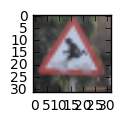

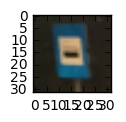

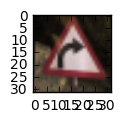

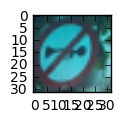

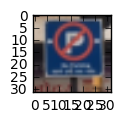

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import tensorflow as tf

real_set = []
for x in range(5):
    
    img = mpimg.imread("images/"+str(x)+".jpg")
    img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    plt.show()

    real_set.append(cv2.cvtColor(img,cv2.COLOR_BGR2YUV))
real_set = np.array(real_set,dtype=np.float32)[:,:,:,0:1]

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The images have been taken from standard Indian roads. The quality reduction caused due to downsampling of the resolution has reduced the quality of the images as well. This could pose a problem for the model as it has been trained on smooth and relatively sharp images.
- Image 1 - Children crossing
- Image 2 - Heavy vehicle (not in dataset but similar to label 10 and 16 for vehicles over 3.5 metric tonnes)
- Image 3 - Right turn ahead (very different from the circular image we have for the same label in dataset)
- Image 4 - No horn (not in the dataset)
- Image 5 - No parking (not in the dataset)

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# keep_prob = tf.placeholder(tf.float32) # probability to keep units
y = tf.placeholder(tf.float32, (None, 32, 32,1))
logs = LeNet(y)
print(y)
predictions = tf.argmax(logs,1)
softmax_prob = tf.nn.top_k(logs,k=3)
saver = tf.train.Saver({"w1": conv1_W,"b1": conv1_b,"w2": conv2_W,"b2": conv2_b,"w3": fc1_W,"b3": fc1_b,"w4": fc3_W,"b4": fc3_b})
with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    saver.restore(sess,os.getcwd()+'/tmp/model.ckpt')
    pre = sess.run([predictions],feed_dict={y:real_set , keep_prob:1})
    print(pre[0])

Tensor("Placeholder_3:0", shape=(?, 32, 32, 1), dtype=float32)
[21  9 37 13 19]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** 

No, the accuracy for 5 different Indian traffic signs came out to be 20%, with only a children crossing sign having been identified correctly. 
There are several reasons for this that have more to do with the data than the model itself.
- The images are much more coarse and unrefined than the dataset images. I tried using Gaussian filters, pyramid_reductions, etc, but the images are simply of lower quality. 
- None of the signs I captured on Indian roads are in the training dataset. Even the children crossing prediction of the model was on an image that looks quite different from the original one on which the model actually trained. If anything this shows how generalized the model has become at making right predictions on even some seemingly different images of the same label. 

In [16]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    saver.restore(sess,os.getcwd()+'/tmp/model.ckpt')
    prob = sess.run([softmax_prob],feed_dict={y:real_set , keep_prob:1})
    print(prob)

[TopKV2(values=array([[ 5137.28027344,  3222.84741211,  2964.04150391],
       [ 7110.57958984,  3942.02807617,  3540.84448242],
       [ 2830.62890625,  2535.16137695,  2533.3203125 ],
       [ 4338.48046875,  3968.43359375,  3109.31079102],
       [ 3582.27050781,  2499.2097168 ,  2164.67089844]], dtype=float32), indices=array([[21, 11, 28],
       [ 9, 13, 16],
       [37, 21, 11],
       [13,  2,  1],
       [19, 13, 21]], dtype=int32))]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

Using the tf.nn.top_k function to get secondary predictions, the model did have an uncertain-yet-correct prediction of the second image i.e the heavy vehicles. This was probably the most unclear image in the dataset, and yet the model's prediction gets it somewhat right. Image 3 was very different from its couterparts in the training dataset, and Image 4 and 5 didn't even have respective labels in the dataset. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.